In [33]:
from Functions import *
from Kernels import *
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import jacobian
import plotly.graph_objects as go
import utils
import time

from postprocessing import *


%load_ext autoreload


%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
exp_root = "/Users/daniellengyel/flat_sharp/toy_examples/experiments/gaussian/{}"
exp_folder = exp_root.format("May06_19-25-51_Daniels-MacBook-Pro-4.local")

get_animation(exp_folder, "1588786729.931386") 

KeyboardInterrupt: 

In [3]:
auto_U = lambda *inp: jacobian(trace_multi_gaussian(np.array([[1]])), 0)(*inp)

In [3]:
def smooth(inp, out, K):
    """Assumes that inp[i] - inp[i-1] = d for all i"""
    k_inp = []
    for x in inp:
        d = x[1] - x[0]
        assert d > 0
        tmp = np.linspace(int(float(-len(x)*d)/2), int(float(len(x)*d)/2), len(x) + 1 - len(x)%2)[:len(x)]
        k_inp.append(tmp)
    k_inp = np.array(k_inp)
    kernel = K(k_inp, np.array([0] * len(inp)))
    return np.convolve(out, kernel, "same")


In [4]:
a = time.time()
for i in inp.T:
    auto_U(np.array([i]), np.array([1]))
print(time.time() -a )

NameError: name 'inp' is not defined

In [58]:
def grad_trace_squared_hessian_multi_gaussian(cov):
    def helper(inp, mu):
        k = inp.shape[0]
        diff = (inp.T - mu).T

        mg = multi_gaussian(cov)(inp, mu)

        cov_inv_prod = np.dot(np.linalg.inv(cov), diff)
        

        C = -np.diag(np.linalg.inv(cov))[:, np.newaxis] + cov_inv_prod * cov_inv_prod
        A = 2 * np.sum(C.T[:, np.newaxis, :] * (np.linalg.inv(cov))[np.newaxis, :, :] * cov_inv_prod.T[:, np.newaxis, :], axis=-1).T
        B = - 2 * np.sum(np.matmul((C * C).T[:, :, np.newaxis], cov_inv_prod.T[:, np.newaxis, :]).T, axis=0)
        grad_term = 2 * A + B
        return mg ** 2 * grad_term

    return helper

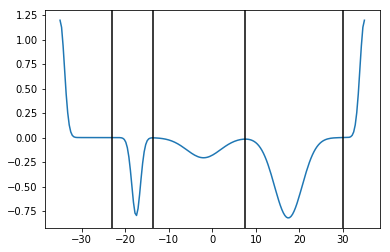

In [126]:
g_params = [[-17.5, 1, -2], [17.5, 10, -6.5], [-2, 15, -2], [-35, 1, 3], [35, 1, 3]]
x = np.linspace(-35, 35, 200)
inp = np.array([x])
out = gaussian_sum(g_params)(inp)
grad_out = grad_gaussian_sum(g_params)(inp)

plt.plot(x, out)
attractive_basins = np.array([[-23.      , -13.625   ], [-13.625   ,   7.609375], [  7.609375,  30.  ]]) # hard coded for now

for a in attractive_basins:
    
    plt.axvline(x=a[0], color="black")

plt.axvline(x=a[1], color="black")


# plt.plot(x, grad_out[0])
# plt.scatter(bees[:, 0], np.zeros(len(bees)))
# plt.scatter(bees[:, 1], np.zeros(len(bees)))

# plt.savefig("simple_gaussian.png")


In [121]:
bees

array([[-35.   ,  -6.   ],
       [ -6.   ,  -5.625],
       [ -5.625,   5.625],
       [  5.625,  30.   ],
       [ 30.   ,  35.   ]])

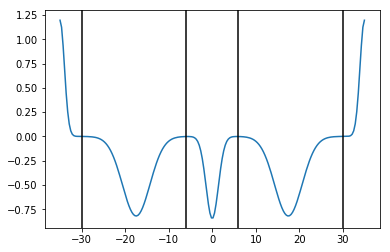

In [123]:
g_params = [[-17.5, 10, -6.5], [0, 2, -3], [17.5, 10, -6.5], [-35, 1, 3], [35, 1, 3]]
x = np.linspace(-35, 35, 200)
inp = np.array([x])
out = gaussian_sum(g_params)(inp)
grad_out = grad_gaussian_sum(g_params)(inp)

plt.plot(x, out)
# plt.plot(x, grad_out[0])
attractive_basins = [[-30, -6], [-6, 6], [6, 30]]
# plt.scatter(bees[:, 0], np.zeros(len(bees)))
# plt.scatter(bees[:, 1], np.zeros(len(bees)))
for a in attractive_basins:
    
    plt.axvline(x=a[0], color="black")

plt.axvline(x=a[1], color="black")


plt.savefig("symmetric_simple_gaussian.png")


In [81]:
def approx_E(f, N, mu, var):
    xs = np.random.normal(loc=mu, scale=var, size=(1, N))
    out = np.sum(np.exp(-f(xs)))/float(N) #* np.sqrt(2 * np.pi * var)
    return -np.log(out)

f = gaussian_sum(g_params)
approx_E(f, 100000, 0, 1)
    

-1.410339017580506e-06

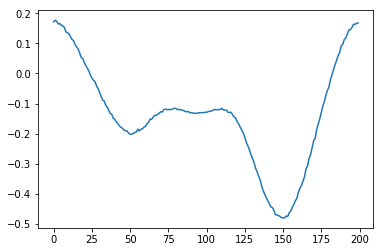

In [128]:
out = []
f = gaussian_sum(g_params)

for x in inp[0]:
    out.append(approx_E(f, 10000, x, 5.))

plt.plot(out)
plt.show()

In [42]:
grad_gaussian_sum(g_params)(np.array([[30]]))

array([[0.00043707]])

In [32]:
bees

array([[-35.      , -29.      ],
       [-29.      , -27.      ],
       [-27.      , -25.      ],
       [-25.      , -23.      ],
       [-23.      , -13.625   ],
       [-13.625   ,  -2.      ],
       [ -2.      ,   7.609375],
       [  7.609375,  35.      ]])

In [28]:
def find_basins(grad_f, bounds, smallest_diameter, eps, plateau_eps):
    """Finds all attractive basisn with smallest diameter given. eps tells us when we can stop finding zero i.e. when we have found x s.t. |f(x)| < eps"""
    n = (bounds[1] - bounds[0])/(smallest_diameter * 2)
    xs = np.linspace(bounds[0], bounds[1], int(n) + 1)
    outs = grad_f(np.array([xs]))[0]
    
    basins = []
    left_p = bounds[0]
    passed_minimum = False
    
    for i in range(1, int(n)):
        out = outs[i]
        
        if (outs[i - 1] >=0 ) and (outs[i] <= 0):
            right_p = binary_search_zero(grad_f, np.array([xs[i - 1]]), np.array([xs[i]]), eps)[0]
            basins.append([left_p, right_p])
            left_p = right_p
        elif (abs(outs[i]) < plateau_eps):
            if not passed_minimum:
                passed_minimum = True
            else:
                right_p = xs[i]
                basins.append([left_p, right_p])
                left_p = right_p
                passed_minimum = False

    if left_p != xs[-1]:
        basins.append([left_p, xs[-1]])
    return np.array(basins)

def binary_search_zero(f, a, b, eps):    
    while True:
        new_x = (b + a)/2.
        if abs(f(new_x)) < eps:
            return new_x
        if any(f(new_x) < 0):
            b = new_x
        else:
            a = new_x
            
        

In [118]:
bees = find_basins(grad_gaussian_sum(g_params), [-35, 35], 0.5, 0.0001, 0.001)

In [119]:
binary_search_zero(grad_gaussian_sum(g_params), np.array([[0]]), np.array([[20]]), 0.00001)

array([[5.63476562]])

In [60]:
A = np.array([[1]])

mu = np.array([0])

diff = (inp.T - mu).T
diff = np.array([[1]])

print(diff.shape)

c = np.dot(A, diff)

b = -np.diag(A)[:, np.newaxis] + c * c

print(b.shape)
print(c.shape)

a = time.time()
temp = b.T[:, np.newaxis, :] * A[np.newaxis, :, :]
print(temp.shape)
s = temp * c[:, np.newaxis, :].T
print(s.shape)
s = np.sum(s, axis=-1)
print(time.time() -a )
print(s)

a = time.time()
t = np.sum(b.T[:, np.newaxis, :] * A[np.newaxis, :, :] * c, axis=-1).T
print(time.time() -a )

a = time.time()
B = - 2 * np.sum(np.matmul((b*b).T[:, :, np.newaxis], c.T[:, np.newaxis, :]).T, axis=0)
print(time.time() - a)
print(t)

assert np.array_equal(s, t)

(1, 1)
(1, 1)
(1, 1)
(1, 1, 1)
(1, 1, 1)
0.0003180503845214844
[[0]]
0.0001373291015625
0.00016880035400390625
[[0]]


In [61]:
a = time.time()
grad_trace_squared_hessian_multi_gaussian(A)(inp, mu)
print(time.time() - a)

(1, 5000)
(1, 5000)
9.298324584960938e-05
0.00036215782165527344
0.0014688968658447266


In [23]:
g_params = [[-10, 1, -2], [0, 10, -1], [10, 3, 1], [-20, 1, 3], [20, 1, 3]]

inp = np.linspace(-20, 20, 5000)
inp = np.array([inp])
U = grad_gaussian_sum(g_params)
reg_U = grad_trace_hessian_gaussian_sum(g_params)

a = time.time()
# reg_U(inp)
U(inp)
print(time.time() - a)

a = time.time()
# reg_U(inp)
reg_U(inp)
print(time.time() - a)


0.0012946128845214844
0.07410812377929688
0.0787348747253418
0.07846212387084961
0.06668424606323242
0.06281208992004395
0.36577486991882324


# 1D functions

In [ ]:
X = np.linspace(-15, 15, 1000)
inp = np.array([X])

out = flat_sharp_gaussian(inp)
K = multi_gaussian(np.array([[10]]))
smooth_out = smooth(inp, out, K) * 0.1

plt.plot(X, out)
plt.plot(X, smooth_out)
plt.show()

In [ ]:
K = multi_gaussian(np.array([[10]]))
X = np.linspace(-15, 15, 1000)
out = K(np.array([X.T]), np.array([0]))

plt.plot(out)
plt.show()


In [ ]:
X = np.linspace(-50, 50, 1000)
inp = np.array([X])

g_params = [[-40, 0.7, -2],[-30, 0.7, -1.5],[-5, 0.7, -1], [35, 0.7, -1.5], 
            [-17.5, 30, -3], [5, 10, -1.5], [14, 3, 1], [25, 10, -0.5], 
            [-50, 1, 3], [50, 1, 3]]
func = gaussian_sum(g_params) # AckleyProblem # 
g_func = GradAckleyProblem # grad_gaussian_sum(g_params)

out = func(inp)
K = multi_gaussian(np.array([[1]]))
smooth_out = smooth(inp, out, K)

out_grad = g_func(inp)
# out_grad = grad(flat_sharp_hill_gaussian)(inp) #grad_flat_sharp_hill_gaussian(inp)

plt.plot(X, out)
# plt.plot(X, out_grad[0])

plt.show()

In [ ]:
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)

inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X)*len(Y))

g_func = GradAckleyProblem
out = g_func(inp)

In [ ]:
np.linalg.norm(g_func(inp), axis=0).shape

In [ ]:
inp[0][0]

In [ ]:
out.shape

In [ ]:
X = np.linspace(-10, 10, 1000)
inp = np.array([X])

out = (inp[0]/1.5)**3 + (inp[0] - 8)**2 + (inp[0] + 4)**2 + (-inp[0]*10 + 4)

plt.plot(X, out)
plt.show()


In [ ]:
X = np.linspace(-2, 2, 1000)
inp = np.array([X])

out = one_D_shallow(inp)
out_grad = grad_one_D_shallow(inp)

plt.plot(X, out)
plt.plot(X, out_grad[0])
plt.show()


# 2D functions

In [ ]:
def multi_gaussian(cov):
    def multi_gaussian_helper(inp, mu):
        """same mu for every datapoint given in ipn"""
        k = inp.shape[0]
        diff = (inp.T - mu).T        
        return 1 / np.sqrt(pow(2 * np.pi, k) * np.linalg.det(cov)) * np.exp(
            -0.5 * np.sum(diff*(np.linalg.inv(cov).dot(diff)), axis=0))
    return multi_gaussian_helper

In [ ]:
def himmelblau_2d(inp):
    x = inp[0]
    y = inp[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 11)**2

In [ ]:
def weight_function_discounted_norm(U, grad_U, x, curr_weights, gamma=1, partials=None):
    grad = grad_U(x.T)
    if partials is not None:
        grad = grad[partials]
    return gamma * curr_weights + np.linalg.norm(grad, axis=0)

In [ ]:
# g_params = [[-40, 0.7, -2],[-30, 0.7, -1.5],[-5, 0.7, -1], [35, 0.7, -1.5], 
#             [-17.5, 30, -3], [5, 10, -1.5], [14, 3, 1], [25, 10, -0.5], 
#             [-50, 1, 3], [50, 1, 3]]
g_params = [[-10, 1, -2], [0, 10, -1], [10, 3, 1], [-20, 1, 3], [20, 1, 3]]

process = {}

process["particle_init"] = {"name": "2d_uniform", 
                            "num_particles": 5000}

process["potential_function"] = {"name": "2d_gaussian_symmetric", #} 
                                 "params": g_params}

process["total_iter"] = 20
process["tau"] = 20
process["x_range"] = [-25, 25]

process["gamma"] = 0.1
process["temperature"] = 0.5
process["epsilon"] = 0

process["weight_function"] = {"name": "norm"} 
process["resample_function"] = {"name": "softmax", "params": {"beta": -0.05}} 

process["domain_enforcer"] = {"name": "hyper_cube_enforcer", "params": {"strength": 0.2}}

In [ ]:
X = np.linspace(-50, 50, 1000)
inp = np.array([X])


func = gaussian_sum(g_params) # AckleyProblem # 
# g_func = GradAckleyProblem # grad_gaussian_sum(g_params)

out = func(inp)
# K = multi_gaussian(np.array([[1]]))
# smooth_out = smooth(inp, out, K)

out_grad = g_func(inp)
# out_grad = grad(flat_sharp_hill_gaussian)(inp) #grad_flat_sharp_hill_gaussian(inp)

plt.plot(X, out)
# plt.plot(X, out_grad[0])

plt.show()

In [ ]:
g_params = [[-10, 1, -2], [0, 10, -1], [10, 3, 1], [-20, 1, 3], [20, 1, 3]]

U, grad_U = utils.get_potential(process)

X = np.linspace(-20, 20, 100)
Y = np.linspace(-20, 20, 100)
inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X)*len(Y))


out = U(inp) #grad_U(inp)[0] #
out = out.reshape(len(X), len(Y))


In [ ]:
K = multi_gaussian(np.array([[10, 5], [5, 5]]))

X = np.linspace(-15, 15, 100)
Y = np.linspace(-15, 15, 100)

X = np.linspace(0, 2, 100)
Y = np.linspace(0, 2, 100)

inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X)*len(Y))

out = K(inp, np.array([0, 0]))
# out = (inp[0] + inp[1]) * 1/8.
#himmelblau_2d(inp)

out = out.reshape(len(X), len(Y))

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=out, x=X, y=Y, colorscale="Viridis")])

fig.update_layout(title='Function', autosize=False,
                  width=1000, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
U(inp)

In [ ]:
inp

In [ ]:
import time

In [ ]:
x_low, x_high, t_low, t_high = -20, 20, 0, 4 # closed interval for spatial and time
delta_x, delta_t = 0.005, 0.000001 # number of points to approximate
sig = 1

process = {"potential_function": {"name": "gaussian", "params": [[-10, 1, -2], [0, 10, -1], [10, 3, 1], [-20, 1, 3], [20, 1, 3]]}}



num_x, num_t = (x_high - x_low)/float(delta_x), (t_high - t_low)/float(delta_t)
# assert (x_high - x_low) // delta_x == num_x
# assert (t_high - t_low) // delta_t == num_t

num_x, num_t = int(num_x) + 1, int(num_t) + 1
u_start = lambda x: 1/float(num_x)

# get potential_function and gradient
# U, grad_U = lambda inp: inp[0]**2, lambda inp: 2 * inp
U, grad_U = utils.get_potential(process)

# init u
u = [np.array([u_start(delta_x * i) for i in range(num_x)])] # 1D is time and rest are space

V = lambda x: np.linalg.norm(grad_U(np.array([[x]])), axis=0)

# create forward matrix
forward_matrix = []

a = time.time()
assert num_x > 3
for i in range(num_x):
    curr_x = x_low + delta_x * i 
    b = grad_U(np.array([[curr_x]]))[0][0]
    
    row = [sig**2 / 2. * delta_t / (delta_x**2) - delta_t*b / (2 * delta_x), - sig**2/2. * 2*delta_t/(delta_x ** 2) - delta_t*V(curr_x)[0] + 1,
     delta_t * b / (2. * delta_x) + sig**2 / 2. * delta_t / (delta_x**2)]
    
    padded_row = [0] * i + row + [0]*(num_x - (i + 1))
    forward_matrix.append(padded_row[1:-1])
    
forward_matrix = np.array(forward_matrix)

print(time.time() - a)

for t in range(num_t):
    u_next = forward_matrix.dot(u[-1])
    u.append(u_next) 
    
print(time.time() - a)

    

In [ ]:
X = np.linspace(-20, 20, num_x)[50: -50]
Y = u[2000][50: -50]

plt.plot(X, Y)
plt.show()

In [ ]:
def f(inp):
    x, y = inp[0], inp[1]
    x = np.maximum(x, 0, x)
    return x * y 


X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)

inp = np.array(np.meshgrid(X, Y)).reshape(2, len(X)*len(Y))

out = f(inp)

out = out.reshape(len(X), len(Y))

fig, ax = plt.subplots()
CS = ax.contour(X, Y, out)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')